# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

## Problem Statement
In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 
<br><br>
This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.
<br><br>
__Author__: Pradeep Kumar S

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
print('Default Working Directory:', os.getcwd())
%cd gdrive/MyDrive/Capstone/
print('Changing Working Directory to:', os.getcwd())

Default Working Directory: /content
/content/gdrive/MyDrive/Capstone
Changing Working Directory to: /content/gdrive/MyDrive/Capstone


In [3]:
!pip install tqdm
!pip install gTTS

In [4]:
# Import helpful utility libraries
from IPython.display import display
from IPython.display import Audio
from collections import Counter
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import warnings
import random
import string
import glob
import time
import os

In [5]:
# importing visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

In [6]:
# importing model building libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model
import tensorflow as tf

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu

In [7]:
# importing text to speech convertor linraries
from gtts import gTTS

In [8]:
## Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

## To suppress Scientific Notation
pd.options.display.float_format = "{:.4f}".format

## Setting display options
pd.set_option('display.max_columns', 100)

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [9]:
# get paths for input data - images and captions
BASE_PATH = os.getcwd()
CAPTIONS_PATH = os.path.join(BASE_PATH, 'data')
IMAGES_PATH = os.path.join(BASE_PATH, 'data', 'Images')
print('Captions Text path:', CAPTIONS_PATH)
print('Images directory path:', IMAGES_PATH)

Captions Text path: /content/gdrive/MyDrive/Capstone/data
Images directory path: /content/gdrive/MyDrive/Capstone/data/Images


In [10]:
# Import the dataset and read the image into a seperate variable
images = IMAGES_PATH

all_imgs = glob.glob(images + '/*.jpg', recursive=True)
print(f"The total images present in the dataset: {len(all_imgs)}")

The total images present in the dataset: 8091


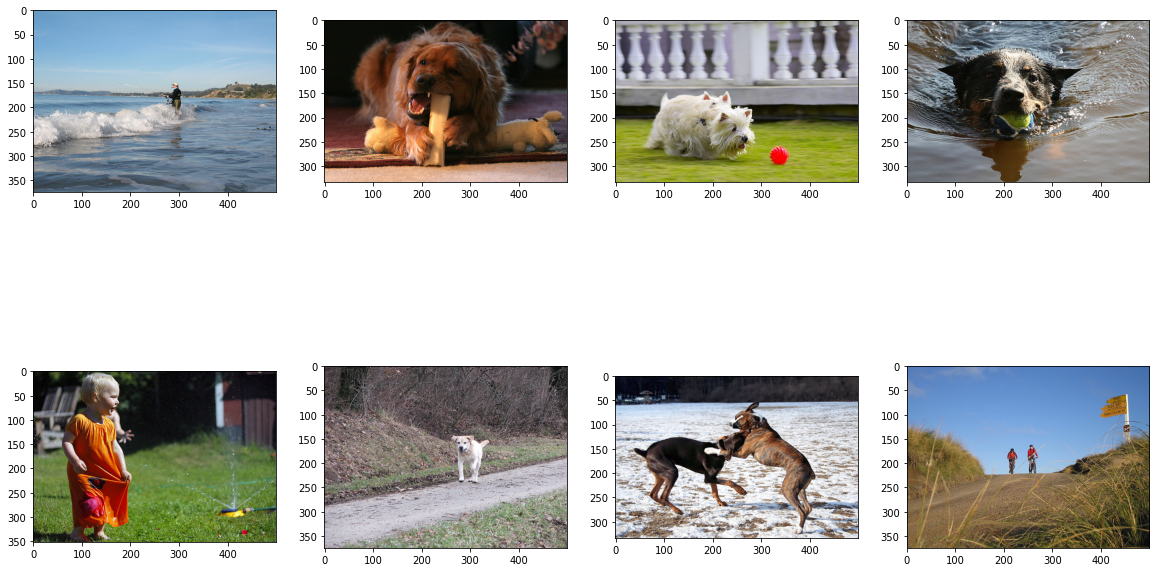

In [11]:
# Visualise both the images & text present in the dataset
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
ax = axes.flatten()
for img, axs in zip(all_imgs[:8], ax):
    image = plt.imread(img)
    axs.imshow(image)
plt.show()

In [12]:
# Import the dataset and read the text file into a seperate variable
text_file = os.path.join(CAPTIONS_PATH, 'captions.txt')

def load_doc(filename):    
    """Loading captions file and return as text"""
    text = pd.read_csv(filename, sep=',')
    return text

doc = load_doc(text_file)
doc[:300]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
295,1077546505_a4f6c4daa9.jpg,A boy in blue shorts slides down a slide into ...
296,1077546505_a4f6c4daa9.jpg,A boy in blue swimming trunks slides down a ye...
297,1077546505_a4f6c4daa9.jpg,A boy rides down a slide into a small backyard...
298,1077546505_a4f6c4daa9.jpg,A boy sliding down a slide into a pool with co...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [13]:
# storing image names
all_img_id = doc.image
# store all the image path here
all_img_vector = map(lambda x: os.path.join(IMAGES_PATH, x), all_img_id) 
#store all the captions here
annotations = doc.caption

# creating dataframe with images, path and captions
df = pd.DataFrame(
    list(zip(all_img_id, all_img_vector, annotations)), 
    columns=['ID', 'Path', 'Captions']
) 
# display contents of dataframe
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Capstone/data/Images/9...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Capstone/data/Images/9...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Capstone/data/Images/9...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Capstone/data/Images/9...,A rock climber in a red shirt .


In [14]:
# information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


##### Visualizing Random Images along with its captions

A black and white Border Collie catches a Frisbee in front of an audience .
a brown and white dog catches a Frisbee in it mouth in front of a group of people .
A brown and white dug jumping up to catch a Frisbee while an audience watches .
A dog jumps to catch a Frisbee , while many people watch .
An agile dog catches a Frisbee while a crowd of onlookers watches closely .


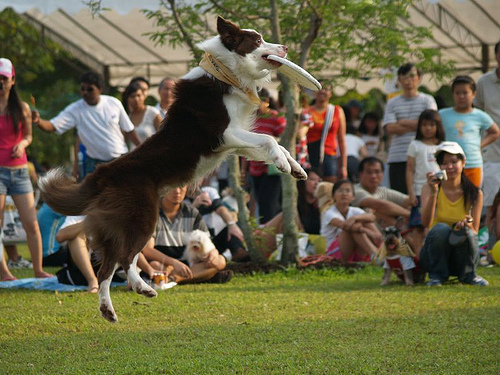

In [15]:
# From index 500
print(
    df.Captions[500], df.Captions[501], df.Captions[502], df.Captions[503], 
    df.Captions[504], sep='\n'
)
Image.open(df.Path[500])

A climber in an orange helmet is ascending attached to a rope whilst climbing a rock face .
A gentleman is rock climbing .
A man rock-climbing
A rock climber ascends .
Downward view of a man with an orange helmet climbing a rock .


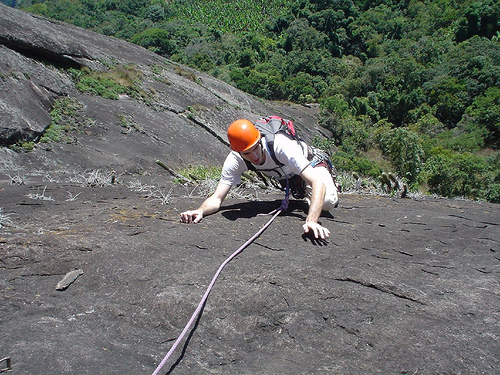

In [16]:
# From index 2000
print(
    df.Captions[2000], df.Captions[2001], df.Captions[2002], df.Captions[2003], 
    df.Captions[2004], sep='\n'
)
Image.open(df.Path[2000])

In [17]:
# Create the vocabulary & the counter for the captions
def define_vocabulary(df, column):
    """Creating vocabulary of words from the captions"""
    vocab = []
    for caption in df[column].values:
        vocab.extend(caption.strip('.,?!"\'').lower().strip().split())
    return vocab

vocabulary = define_vocabulary(df, 'Captions')

val_count = Counter(vocabulary)
print('Size of Vocabulary:', len(set(vocabulary)))
print('Top 30 words in Vocabulary:', val_count.most_common(30))

Size of Vocabulary: 8918
Top 30 words in Vocabulary: [('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), (',', 3210), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268), ('dogs', 2125)]


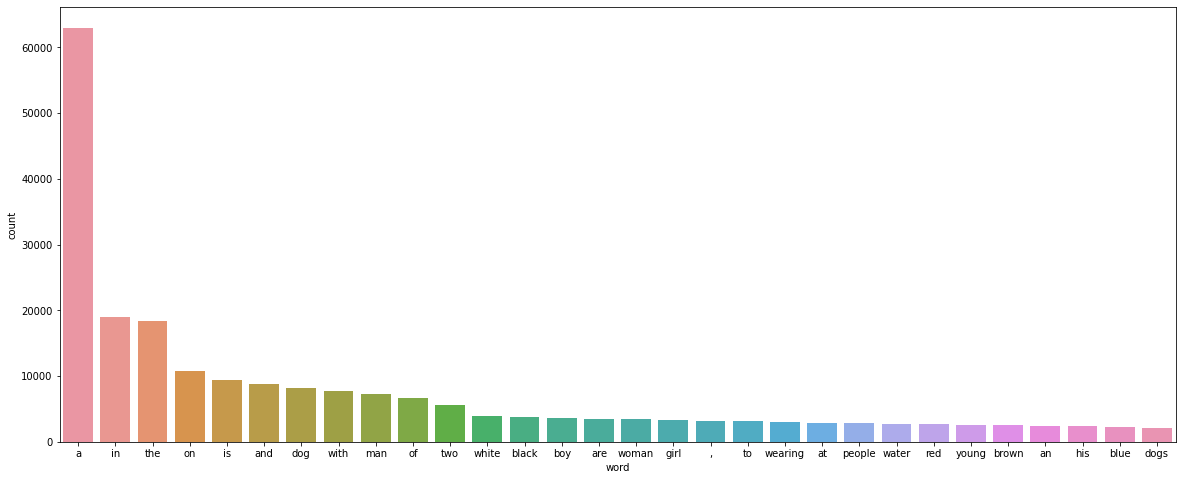

In [18]:
# Visualise the top 30 occuring words in the captions
top_30_words = pd.DataFrame(val_count.most_common(30), columns=['word', 'count'])
plt.figure(figsize=(20, 8))
sns.barplot(x=top_30_words['word'], y=top_30_words['count'])
plt.show()

In [19]:
# displaying the dataframe
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,Two dogs on pavement moving toward each other .


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [20]:
# clean the captions
def remove_special_characters(caption):
    """Function to remove special characters from the caption text"""
    translator = str.maketrans('', '', string.punctuation)
    return caption.translate(translator)

def remove_single_and_numeric_characters(caption):
    """Function to remove numeric and single characters from the caption text"""
    return ' '.join(
        [word for word in caption.split() if len(word) > 1 and word.isalpha()]
    )

def remove_numeric_characters(caption):
    """Function to remove numeric and single characters from the caption text"""
    return ' '.join(
        [word for word in caption.split() if word.isalpha()]
    )

def clean_captions(caption):
    """Function to clean caption text from numerics and special characters"""
    clean_text = remove_special_characters(caption)
    clean_text = remove_numeric_characters(caption)
    return clean_text

In [21]:
# cleaning the captions column in the dataframe
df['Captions'] = df['Captions'].apply(lambda x: clean_captions(x))
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,A little girl in a pink dress going into a woo...


In [22]:
# checking vocabulary size after cleaning the captions
vocabulary = define_vocabulary(df, 'Captions')

val_count = Counter(vocabulary)
print('Size of Vocabulary:', len(set(vocabulary)))
print('Top 30 words in Vocabulary:', val_count.most_common(30))

Size of Vocabulary: 8369
Top 30 words in Vocabulary: [('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268), ('dogs', 2125), ('running', 2073)]


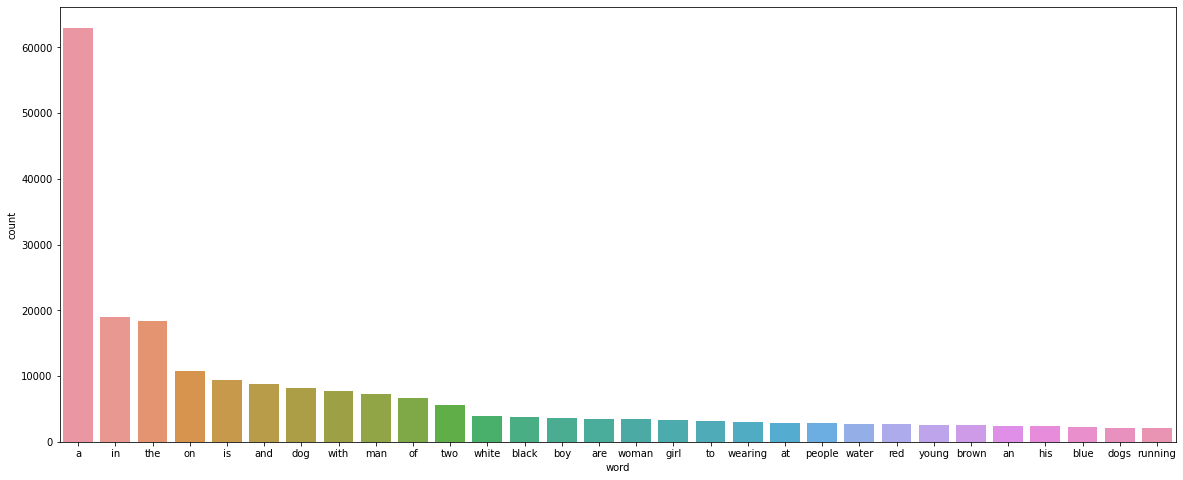

In [23]:
# Visualise the top 30 occuring words after cleaning captions
top_30_words_after_clean = pd.DataFrame(
    val_count.most_common(30), columns=['word', 'count']
)
plt.figure(figsize=(20, 8))
sns.barplot(x=top_30_words_after_clean['word'], y=top_30_words_after_clean['count'])
plt.show()

In [24]:
# Create a list which contains all the captions
annotations = df['Captions'].to_list()

# add the <start> & <end> token to all those captions as well
df['Captions'] = df['Captions'].apply(
    lambda caption: '<start> ' + caption + ' <end>'
)

# Create a list which contains all the path to the images
all_img_path = df['Path'].to_list()

print("Total captions present in the dataset:", len(annotations))
print("Total images present in the dataset:", len(all_img_path))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [25]:
# checking vocabulary size after adding start and end tags
vocabulary = define_vocabulary(df, 'Captions')

val_count_with_tags = Counter(vocabulary)
print('Size of Vocabulary:', len(set(vocabulary)))
print('Top 30 words in Vocabulary:', val_count_with_tags.most_common(30))

Size of Vocabulary: 8371
Top 30 words in Vocabulary: [('a', 62986), ('<start>', 40455), ('<end>', 40455), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268)]


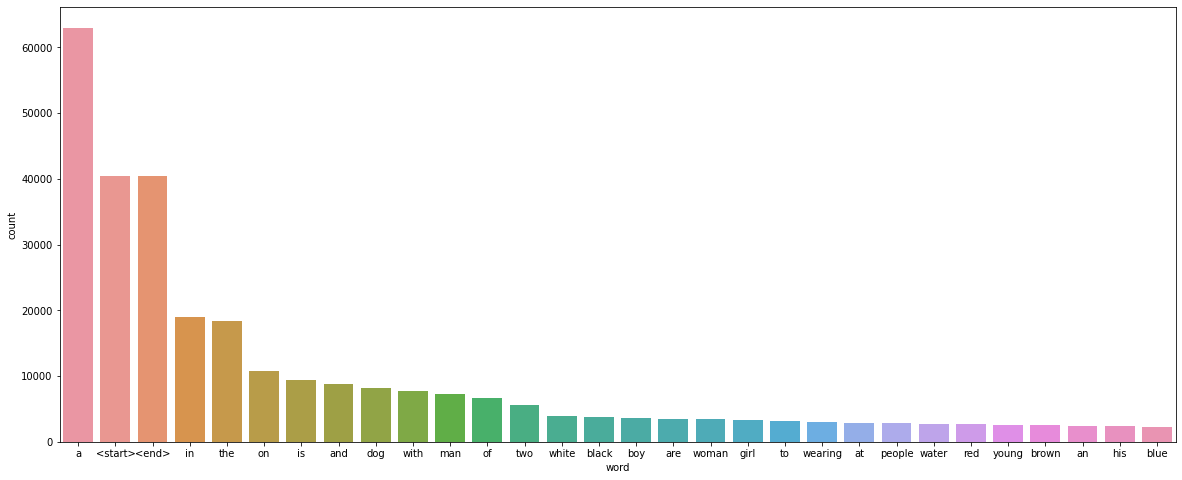

In [26]:
# Visualise the top 30 occuring words in the captions after adding tags
top_30_words_with_tags = pd.DataFrame(
    val_count_with_tags.most_common(30), columns=['word', 'count']
)
plt.figure(figsize=(20, 8))
sns.barplot(x=top_30_words_with_tags['word'], y=top_30_words_with_tags['count'])
plt.show()

In [27]:
# display dataframe after adding tags to captions
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A girl going into a wooden building <end>
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A little girl in a pink dress going in...
5,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A black dog and a spotted dog are figh...
6,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A black dog and a dog playing with eac...
7,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> A black dog and a white dog with brown...
8,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> Two dogs of different breeds looking a...
9,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Capstone/data/Images/1...,<start> Two dogs on pavement moving toward eac...


In [28]:
# create the tokenizer
final_vocabulary = define_vocabulary(df, 'Captions')
final_annotations = df['Captions'].to_list()
top_vocab_count = 5000

filter_special_chars = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n '
tokenizer = Tokenizer(
    num_words=top_vocab_count, filters=filter_special_chars, oov_token='<unk>'
)
tokenizer.fit_on_texts(final_annotations)

In [29]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

text_to_sequences = tokenizer.texts_to_sequences(final_annotations)
text_to_sequences[:5]

[[3, 2, 43, 5, 2, 91, 170, 8, 120, 54, 2, 394, 13, 391, 5, 29, 1, 692, 4],
 [3, 2, 20, 313, 65, 2, 194, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 194, 2405, 4],
 [3, 2, 41, 20, 120, 6, 391, 21, 61, 2405, 4],
 [3, 2, 41, 20, 5, 2, 91, 170, 313, 65, 2, 194, 2952, 4]]

In [30]:
# display annotations/captions
final_annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> A girl going into a wooden building <end>',
 '<start> A little girl climbing into a wooden playhouse <end>',
 '<start> A little girl climbing the stairs to her playhouse <end>',
 '<start> A little girl in a pink dress going into a wooden cabin <end>']

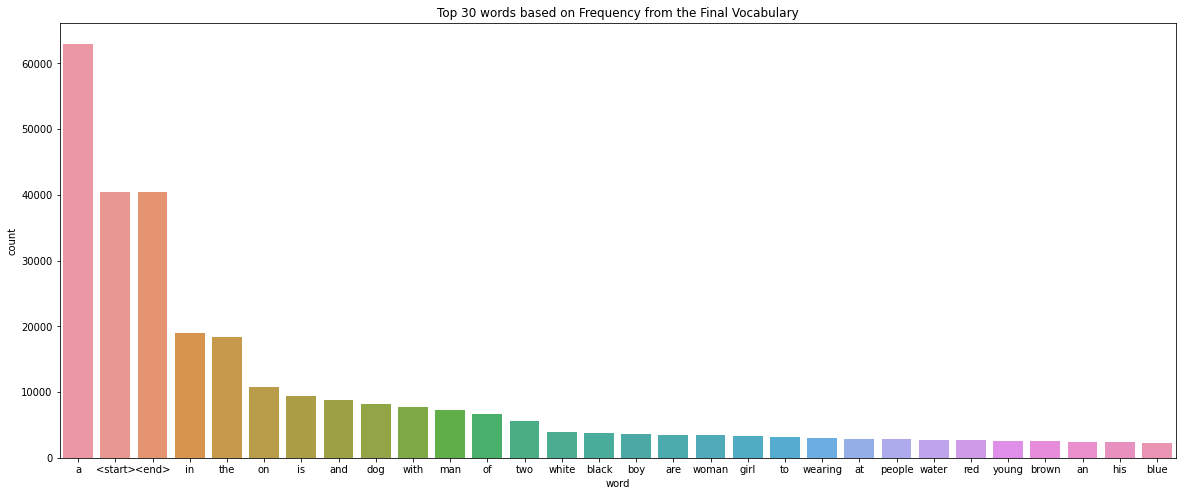

In [31]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
final_val_count_with_tags = Counter(final_vocabulary)

final_top_30_words = pd.DataFrame(
    final_val_count_with_tags.most_common(30), columns=['word', 'count']
)
plt.figure(figsize=(20, 8))
sns.barplot(x=final_top_30_words['word'], y=final_top_30_words['count'])
plt.title('Top 30 words based on Frequency from the Final Vocabulary')
plt.show()

In [32]:
# Find maximum length in the given captions list
def get_max_caption_length(caption_list):
    """Get the maximum caption length"""
    return max([len(caption.split()) for caption in caption_list])

max_length = get_max_caption_length(df['Captions'].to_list())
print('The maximum lenght of a caption is:', max_length)

The maximum lenght of a caption is: 36


In [33]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
    text_to_sequences, padding='post', maxlen=max_length,
)

print('The shape of Caption vector is:', cap_vector.shape)

The shape of Caption vector is: (40455, 36)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [34]:
# write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    """Preprocess images and return images and their path"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [35]:
# write your code here for applying the function to the image path dataset, 
# such that the transformed dataset should contain images & their path
BATCH_SIZE = 32
AUTO_TUNE = tf.data.experimental.AUTOTUNE

unique_image_path_data = sorted(set(df['Path'].to_list()))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_image_path_data)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=AUTO_TUNE
).batch(BATCH_SIZE)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [36]:
# loading pre trained model -  InceptionV3
image_model = tf.keras.applications.InceptionV3(
    include_top=False, input_shape=(299, 299, 3), weights='imagenet'
)

# write code here to get the input of the image_model
new_input = image_model.input
# write code here to get the output of the image_model
hidden_layer = image_model.layers[-1].output

# build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [37]:
# model summary
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [38]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3])
    )
    for batch_feature, path in zip(batch_features, path):
        path_feature = path.numpy().decode('utf-8')
        np.save(path_feature, batch_feature.numpy())

100%|██████████| 253/253 [43:22<00:00, 10.28s/it]


In [39]:
# shape of batch feature size
batch_feature.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [40]:
# splitting the dataframe in to train and test set
path_train, path_test, cap_train, cap_test = train_test_split(
    df['Path'], cap_vector, test_size=0.2, random_state=100
)

In [41]:
# display shapes of train and test set
print("Training data for images:", len(path_train))
print("Testing data for images:", len(path_test))
print("Training data for Captions:", len(cap_train))
print("Testing data for Captions:", len(cap_test))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [42]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
def map_func(image_name, caption):
    """Function to associate image tensor with its caption"""
    img_tensor = np.load(image_name.decode('utf-8') + '.npy')
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [43]:
# defining buffer size
BUFFER_SIZE = 1000

In [44]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
def gen_dataset(image_data, caption_data):
    """Generate dataset after shuffling and prefetch"""
    dataset = tf.data.Dataset.from_tensor_slices((image_data, caption_data))
    # loading numpy files in parallel using map
    dataset = dataset.map(
        lambda item_1, item_2: tf.numpy_function(
            map_func, [item_1, item_2], [tf.float32, tf.int32]
        ), num_parallel_calls=AUTO_TUNE
    )

    # shuffle and prefetch batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=AUTO_TUNE)
    return dataset

In [45]:
# generating train and test set
train_dataset = gen_dataset(path_train, cap_train)
test_dataset = gen_dataset(path_test, cap_test)

In [46]:
# sample image and caption batch
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  # (batch_size, 8*8, 2048)
print(sample_cap_batch.shape)  # (batch_size,max_len)

(32, 64, 2048)
(32, 36)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [47]:
# setting Hyperparameters
embedding_dim = 256 
units = 512
vocab_size = top_vocab_count + 1  # top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
features_shape = batch_feature.shape[1]
attention_features_shape = batch_feature.shape[0]

In [48]:
# number of training steps
train_num_steps

1011

### Encoder

In [49]:
# defining Encoder class - CNN
class Encoder(Model):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [50]:
# instantiating encoder object
encoder = Encoder(embedding_dim)

### Attention model

In [51]:
# defining attention model
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )
        # build score funciton to shape: (batch_size, 8*8, units)
        score = self.V(attention_hidden_layer)
        # extract attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # shape: creating context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Decoder

In [52]:
# defining Decoder class
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # initialise the Attention model with units
        self.attention = Attention_model(units=self.units)
        # build the Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(
            self.units, return_sequences=True, return_state=True, 
            recurrent_initializer='glorot_uniform'
        )
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self, x, features, hidden):
        # creating context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate input with the context vector from attention layer.
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat(
            [tf.expand_dims(context_vector, 1), embed], axis=-1
        )
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [53]:
# instantiating decoder object
decoder = Decoder(embedding_dim, units, vocab_size)

In [54]:
# verifying the encoder and decoder output dimensions
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))  # (batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape))  # (batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))  # (batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [55]:
# define optimizers and loss
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

In [56]:
# defining loss function
def loss_function(real, pred):
    """Calculate loss for pred values against actual"""
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
# define checkpoint parameters and manager
checkpoint_path = os.path.join(BASE_PATH, 'checkpoints')
ckpt = tf.train.Checkpoint(
    encoder=encoder, decoder=decoder, optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
# defining start epoch based on latest checkpoint
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [59]:
# defining custom train step function
@tf.function
def train_step(img_tensor, target):
    """Custom train step"""
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1
    )
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    avg_loss = loss / int(target.shape[1])
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [60]:
# defining custom test step function
@tf.function
def test_step(img_tensor, target):
    """Custom test step"""
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1
    )
    
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        pred_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([pred_id] * target.shape[0], 1)

    avg_loss = loss / int(target.shape[1])     
    return loss, avg_loss

In [61]:
# defining funtion to calculate loss on test dataset
def test_loss_cal(test_dataset):
    """Calculate loss for test dataset"""
    total_loss = 0
    for batch, (img_tensor, target) in enumerate(test_dataset):
        batch_loss, avg_loss = test_step(img_tensor, target)
        total_loss += avg_loss
    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss

In [62]:
# training the model
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss = 100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss = total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print (f"For epoch: {epoch + 1}, The Train loss is {avg_train_loss: 0.3f}, & Test loss is {test_loss: 0.3f}")
    print (f"Time taken for 1 epoch: {time.time() - start: 0.4f} sec\n")
    
    if test_loss < best_test_loss:
        print(f"Test loss has been reduced from {best_test_loss: 0.3f} to {test_loss: 0.3f}")
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, The Train loss is  1.289, & Test loss is  2.005
Time taken for 1 epoch:  380.4047 sec

Test loss has been reduced from  100.000 to  2.005


  7%|▋         | 1/15 [06:21<1:29:02, 381.64s/it]

For epoch: 2, The Train loss is  1.030, & Test loss is  1.967
Time taken for 1 epoch:  312.1686 sec

Test loss has been reduced from  2.005 to  1.967


 20%|██        | 3/15 [16:46<1:05:32, 327.70s/it]

For epoch: 3, The Train loss is  0.937, & Test loss is  1.969
Time taken for 1 epoch:  311.2153 sec



 27%|██▋       | 4/15 [21:55<58:44, 320.40s/it]  

For epoch: 4, The Train loss is  0.870, & Test loss is  2.024
Time taken for 1 epoch:  309.1709 sec



 33%|███▎      | 5/15 [27:03<52:39, 315.92s/it]

For epoch: 5, The Train loss is  0.814, & Test loss is  2.051
Time taken for 1 epoch:  307.9431 sec



 40%|████      | 6/15 [32:13<47:06, 314.06s/it]

For epoch: 6, The Train loss is  0.764, & Test loss is  2.087
Time taken for 1 epoch:  310.4332 sec



 47%|████▋     | 7/15 [37:24<41:44, 313.05s/it]

For epoch: 7, The Train loss is  0.718, & Test loss is  2.100
Time taken for 1 epoch:  310.9298 sec



 53%|█████▎    | 8/15 [42:34<36:23, 311.95s/it]

For epoch: 8, The Train loss is  0.678, & Test loss is  2.172
Time taken for 1 epoch:  309.5784 sec



 60%|██████    | 9/15 [47:43<31:06, 311.14s/it]

For epoch: 9, The Train loss is  0.640, & Test loss is  2.241
Time taken for 1 epoch:  309.3129 sec



 67%|██████▋   | 10/15 [52:54<25:54, 310.84s/it]

For epoch: 10, The Train loss is  0.606, & Test loss is  2.302
Time taken for 1 epoch:  310.1455 sec



 73%|███████▎  | 11/15 [58:06<20:44, 311.22s/it]

For epoch: 11, The Train loss is  0.573, & Test loss is  2.354
Time taken for 1 epoch:  312.0604 sec



 80%|████████  | 12/15 [1:03:16<15:32, 310.85s/it]

For epoch: 12, The Train loss is  0.545, & Test loss is  2.461
Time taken for 1 epoch:  309.9758 sec



 87%|████████▋ | 13/15 [1:08:26<10:21, 310.78s/it]

For epoch: 13, The Train loss is  0.518, & Test loss is  2.482
Time taken for 1 epoch:  310.5912 sec



 93%|█████████▎| 14/15 [1:13:37<05:10, 310.75s/it]

For epoch: 14, The Train loss is  0.493, & Test loss is  2.602
Time taken for 1 epoch:  310.6576 sec



100%|██████████| 15/15 [1:18:48<00:00, 315.23s/it]

For epoch: 15, The Train loss is  0.471, & Test loss is  2.666
Time taken for 1 epoch:  310.9889 sec



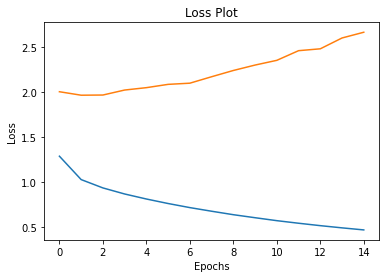

In [63]:
# plot train and test losses
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [64]:
# defining Greedy search evaluation function
def greedy_search_evaluate(image):
    """Evaluate model by Greedy search method"""
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden
        )
        attention_plot[i] = tf.reshape(attention_weights[0][0], (-1, )).numpy()
        # extract the predicted id(embedded value) which carries the max value
        # mapping id to the word from tokenizer and append value to result list
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

### Beam Search(optional)

In [65]:
# defining evaluation function using beam search method
def beam_evaluate(image, beam_index=3):
    """Evaluate the model using Beam search method"""
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.]]

    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < max_length:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(
                dec_input, features, hidden
            )
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i += 1
            pred_words = np.argsort(predictions[0])[-beam_index:]
            for word in pred_words:
                next_caption, prob = s[0][:], s[1]
                next_caption.append(word)
                prob += np.log(predictions[0][word])
                temp.append([next_caption, prob])

        result = temp
        result = sorted(result, reverse=False, key=lambda x: x[1])
        result = result[-beam_index:]

        pred_id = result[-1]
        pred_list = pred_id[0]

        if pred_list[-1] != 3:
            dec_input = tf.expand_dims([pred_list[-1]], 0)
        else:
            break

    res = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in res]
    
    final_caption = []
    for word in intermediate_caption:
        if word != '<end>':
            final_caption.append(word)
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [66]:
# defining a function to plot attention maps
def plot_attmap(caption, weights, image):
    """Plot attention feature maps as images"""
    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8, 8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap // 2, len_cap // 2, cap + 1)
        ax.set_title(caption[cap], fontsize=15)
        
        img = ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [67]:
# instantiating smotthing class to use smoothie method
smoothie = SmoothingFunction().method4

In [68]:
# defining funtion to filter out codes out of captions
def filt_text(text):
    """Filter out codes out of captions"""
    filt = ['<start>','<unk>','<end>'] 
    temp = text.split()
    [temp.remove(j) for k in filt for j in temp if k == j]
    text = ' '.join(temp)
    return text

In [69]:
# defining features shape and attention features shape
features_shape = batch_feature.shape[1]
attention_features_shape = batch_feature.shape[0]

BLEU-1 score: 31.55984539112945
BLEU-2 score: 21.820164702844586
BLEU-3 score: 9.960238411119947
BLEU-4 score: 0.992063492063492
Real Caption: cars racing on a dirt track
Prediction Caption: ralley cars muscle for position on a dirt track


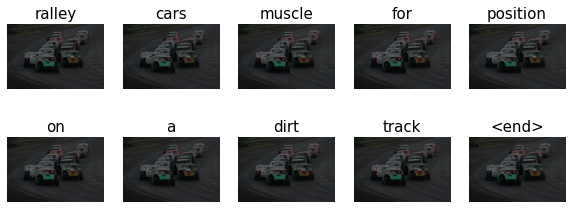

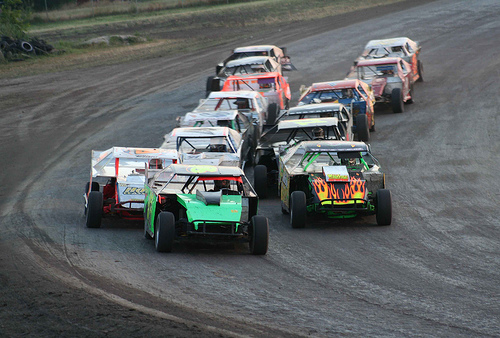

In [70]:
# testing the model using random images from validation set
rid = random.sample(list(path_test.index), 1)[0]
test_image = path_test.iloc[-1]

real_seq = cap_test[-1]
real_caption = ' '.join([tokenizer.index_word[i] for i in real_seq if i not in [0]])
result, attention_plot,pred_test = greedy_search_evaluate(test_image)

real_caption = filt_text(real_caption)      
pred_caption = ' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
score2 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0.33), smoothing_function=smoothie)
score3 = sentence_bleu(reference, candidate, weights=(0.50, 0.50, 0.50, 0.50), smoothing_function=smoothie)
score4 = sentence_bleu(reference, candidate, weights=(1.00, 1.00, 1.00, 1.00), smoothing_function=smoothie)

print(f"BLEU-1 score: {score1 * 100}")
print(f"BLEU-2 score: {score2 * 100}")
print(f"BLEU-3 score: {score3 * 100}")
print(f"BLEU-4 score: {score4 * 100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)

plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [71]:
# evaluating captions using beam search
test_image = os.path.join(IMAGES_PATH, '42637986_135a9786a6.jpg')
captions = beam_evaluate(test_image)
print(captions)

two people sitting on a lamp by a lamp post and near large lake


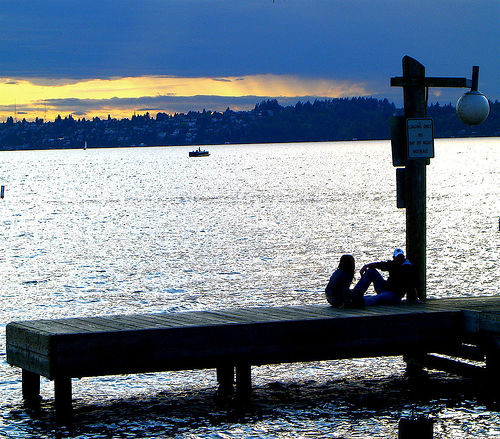

In [72]:
# test image
Image.open(test_image)

## Text to Speech Conversion

In [73]:
# preferred language of conversion
language = 'en'

In [74]:
# passing text and language to the engine
speech_eng = gTTS(text=pred_caption, lang=language)

# saving the converted speech in to MP3 file
speech_eng.save('Predicted_Caption.mp3')

In [75]:
# playing the speech file
os.system('./Predicted_Caption.mp3')

32256